# Загрузка библиотек

In [5]:
import os
import json
import torch

import numpy as np

from glob import glob
from transformers import MarkupLMFeatureExtractor, MarkupLMProcessor, MarkupLMForTokenClassification
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm import tqdm

# Configuration

In [6]:
batch_size = 4
fout_model = "title_date_tag.pth"

allowed_labels = ["title", "short_text", "date", "time", "tag", "short_title", "author"]


label2id = {"OTHER" : 0,
            "title" : 1, 
            "short_text" : 0, 
            "date" : 2, 
            "time" : 2, 
            "tag" : 3, 
            "short_title" : 0, 
            "author" : 0}

id2label = {0: "OTHER",
            1 : "title",
            2 : "date",
            3 : "tag"}

# label2id = {label: idx+1 for idx, label in enumerate(allowed_labels)}
# label2id["OTHER"] = 0

# id2label = {idx+1: label for idx, label in enumerate(allowed_labels)}
# id2label[0] = "OTHER"

# Загрузка данных

In [7]:
def load_from_folder(folder_path : str):
    '''
        This function loading all json files from folder.
        Each file contains dict with labels and its values.
        Each file must contains "html" label with its html code. 
        Each file must contains "xpaths" label with its labeled xpaths list. 
        
    '''
    extractor = MarkupLMFeatureExtractor()
    
    folder_path = os.path.abspath(folder_path)
    files_path = glob(os.path.join(folder_path, "*.json"))
    
    data = []
    
    for file_path in tqdm(files_path):
        # print(file_path)
        with open(file_path) as file:
            info = json.load(file)
            
        html = info["html"]
        labeled_xpaths = info["labeled_xpaths"]

        encoding = extractor(html)
            
        
        labels = []
        for xpath in encoding["xpaths"][0]:
            if xpath in labeled_xpaths.keys():
                labels.append(label2id[labeled_xpaths[xpath]])
            else:
                labels.append(0)
            
        # if (len([_ for _ in labels if _ !=  0]) == 0):
        #     raise Exception("No labeled data found")

        
        labels = [labels]
        
        data.append({'nodes': encoding['nodes'],
                     'xpaths': encoding['xpaths'],
                     'node_labels': labels,
                     'html': html})
        
    return data
    

In [8]:
train_data = load_from_folder("test_dataset/train_part")
valid_data = load_from_folder("test_dataset/test_part")

100%|██████████| 867/867 [00:35<00:00, 24.49it/s]


In [9]:
print("Train size : ", len(train_data))
print("Test size : ", len(valid_data))
print("Train proportion : ", len(train_data) / (len(valid_data) + len(train_data)))

Train size :  2599
Test size :  867
Train proportion :  0.7498557414887478


In [10]:
idx = 256
for node, label in zip(valid_data[idx]['nodes'][0], valid_data[idx]['node_labels'][0]):
  if id2label[label] == 'title':
    print(node, id2label[label])
  # print(node, id2label[label])

Jurist Narmin: The number of bankruptcy in Cuba has almost doubled title
Transfer of FF assets as bonds Ukraine will have to respond. title
Jeff Beos is about to sell about 50 million shares of the giant Amazon. title
The analysts discovered what would happen to the ruble, oil and the exchange market until 11 February title
The Wolgograd FAS has entered the " black list " of the pirate company title
In Astrahani, petrol and diesel prices did not change title
Russia will undergo the largest monetary reform since the 1990s. title
More than 11.7 million roubles of maternal capital have been stolen by 27 Australians title
The Etalon Group will trade in the London Exchange before delicting on 6 February title
The Australian region ' s budget increased by 18 billion roubles title
Cliningrades ' savings in banks increased by 25% title
The Antonov analyst called a reason why the dollar would keep it in 95 rubles. title
Income from NDFL increased its share in the Kaliningrad budget by 8.5 per c

# Инициалиация датасета

In [11]:
class MarkupLMDataset(Dataset):
    """Dataset for token classification with MarkupLM."""

    def __init__(self, data, processor=None):
        self.processor = processor
        newdata = []
        for item in tqdm(data):
            nodes, xpaths, node_labels = item['nodes'], item['xpaths'], item['node_labels']
            encoding = self.processor(nodes=nodes, xpaths=xpaths, stride=20, node_labels=node_labels, padding="max_length", truncation=True, return_tensors="pt", return_overflowing_tokens=True)
            for idx in range(len(encoding['labels'])):
                newdata += [{k: v[idx].squeeze() for k, v in encoding.items()}]

        self.data = newdata

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # first, get nodes, xpaths and node labels
        item = self.data[idx]
        # nodes, xpaths, node_labels = item['nodes'], item['xpaths'], item['node_labels']

        # provide to processor
        # encoding = self.processor(nodes=nodes, xpaths=xpaths, node_labels=node_labels, padding="max_length", truncation=True, return_tensors="pt", return_overflowing_tokens=False)
        # encoding = self.processor(nodes=nodes, xpaths=xpaths, stride=2, node_labels=node_labels, padding="max_length", truncation=True, return_tensors="pt", return_overflowing_tokens=True)
      

        # remove batch dimension
        # encoding = {k: v.squeeze() for k, v in encoding.items()}
        return item

In [12]:
processor = MarkupLMProcessor.from_pretrained("microsoft/markuplm-base", truncation = True)
processor.parse_html = False

train_set = MarkupLMDataset(data=train_data, processor=processor)
valid_set = MarkupLMDataset(data=valid_data, processor=processor)

100%|██████████| 867/867 [00:44<00:00, 19.32it/s]


In [13]:
example = valid_set[1]
for k,v in example.items():
  print(k,v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
overflow_to_sample_mapping torch.Size([])
xpath_tags_seq torch.Size([512, 50])
xpath_subs_seq torch.Size([512, 50])
labels torch.Size([512])


In [14]:
processor.decode(example['input_ids'])

"<s> have been hit by a Ukrainian drone over the Belgorod Region - MS FAccidents17:22Putin and Lukashenko examined SCA Aren at Petersburg.Powersports17:19Unknown ruins the portrait of Holocaust victims at the Leipzig exhibitionAccidentsAbroad16:58Traffic in the area of Theatre is fully restored after the firetransportAccidents16:47Putin noted the contribution of the Navy's military personnel to the preservation of Russia's fleet history.PowerPolicy16:45Two people were injured when Gorlovki was shot by the U.S.Accidentsregions16:22The aborted play in Theatre was visited by Theatre Mossovet.CultureAccidents16:14The Earth has 10 thousand years of warmth ahead of the Earth - PFMPolicyEnvironment15:59Worruk Teatra, Commissioner of Viktor NovikovCulture15:53Rusophobia in the West will last decades, but common sense prevails - Peskov.PowerPolicy15:40CC initiated the case after the beatings of the Yzvestya journalists.Accidents15:26Putin started the winter station at the Antarctic.PowerPolicyS

In [15]:
for id, label in zip(example['input_ids'].tolist(), example['labels'].tolist()):
    if label != -100:
        print(processor.decode([id]), label)
    # if label == 1:
    #     print(processor.decode([id]), label)

Acc 3
17 0
Putin 0
Power 3
sports 3
17 0
Unknown 0
Acc 3
Ab 3
16 0
Tra 0
trans 3
Acc 3
16 0
Putin 0
Power 3
Policy 3
16 0
Two 0
Acc 3
reg 3
16 0
The 0
C 3
Acc 3
16 0
The 0
Policy 3
Environment 3
15 0
W 0
C 3
15 0
Rus 0
Power 3
Policy 3
15 0
CC 0
Acc 3
15 0
Putin 0
Power 3
Policy 3
Science 3
Policy 0
Today 0
Putin 1
19 2
Power 3
Policy 3
C 1
19 2
Policy 3
Putin 1
18 2
Power 3
Policy 3
Putin 1
18 2
Power 3
Policy 3
Econom 3
Z 1
18 2
Policy 3
The 1
17 2
Policy 3
Putin 1
16 2
Power 3
Policy 3
Rus 1
15 2
Power 3
Policy 3
Putin 1
15 2
Power 3
Policy 3
Science 3
The 1
11 2
Policy 3
P 1
11 2
Power 3
Policy 3
M 1
08 2
Policy 3
The 1


In [16]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [17]:
model = MarkupLMForTokenClassification.from_pretrained("microsoft/markuplm-base", id2label=id2label, label2id=label2id)

if os.path.exists(fout_model):
    model.load_state_dict(torch.load(fout_model))
    print("Model Loaded")
else:
    print("Its new model")

Some weights of MarkupLMForTokenClassification were not initialized from the model checkpoint at microsoft/markuplm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded


# TRAIN

In [18]:
import datetime

best_metric = 0

train_history = []
test_history = []

def train_model(): 
    model.train()

    labels_true = []
    labels_predicted = []

    for batch in tqdm(train_dataloader):
        # get the inputs;
        inputs = {k:v.to(device) for k,v in batch.items()}
        inputs.pop("overflow_to_sample_mapping")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # print("Loss:", loss.item())

        predictions = outputs.logits.argmax(dim=-1)

        labels_predicted += predictions[0].tolist()
        labels_true += inputs["labels"][0].tolist()

    score = classification_report(labels_true, labels_predicted, output_dict=True, zero_division=0)['macro avg']['f1-score']
    with open("out_log.txt", "a") as logfile:
        print(datetime.datetime.now())
        print("Train : \n", score, file=logfile)

    train_history.append(score)
    with open("train_history.json", "w") as f:
        json.dump(train_history, f)

    print(f"Train : {score}")


def test_model():
    model.eval()

    global best_metric
    labels_true = []
    labels_predicted = []

    for batch in tqdm(valid_dataloader):
        # get the inputs;
        inputs = {k:v.to(device) for k,v in batch.items()}
        inputs.pop("overflow_to_sample_mapping")


        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(**inputs)

        predictions = outputs.logits.argmax(dim=-1)

        labels_predicted += predictions[0].tolist()
        labels_true += inputs["labels"][0].tolist()

    score = classification_report(labels_true, labels_predicted, output_dict=True, zero_division=0)
    with open("out_log.txt", "a") as logfile:
        print(datetime.datetime.now())
        print("Test : \n", score, file=logfile)
    
    score_f1 = score['macro avg']['f1-score']

    if score_f1 > best_metric:
        best_metric = score_f1     
        torch.save(model.state_dict(), fout_model)

    test_history.append(score_f1)
    with open("test_history.json", "w") as f:
        json.dump(test_history, f)
    print(f"Test : {score_f1}")

In [19]:
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, f1_score

optimizer = AdamW(model.parameters(), lr=5e-6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(device)
for epoch in range(0):
    print(f"Epoch {epoch}")
    train_model()
    test_model()
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


cuda


# TEST

  0%|          | 0/711 [00:00<?, ?it/s]

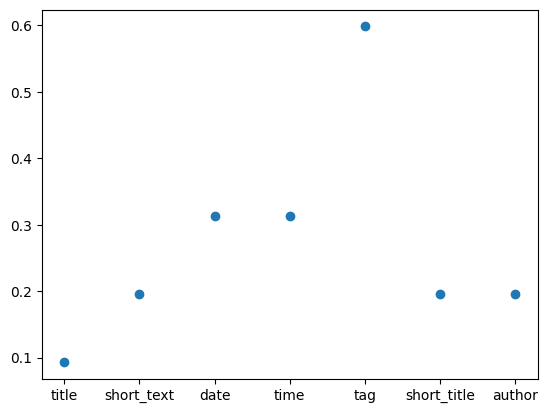

In [21]:
import matplotlib.pyplot as plt

model.eval()

labels_true = []
labels_predicted = []

for batch in tqdm(valid_dataloader):
    # get the inputs;
    inputs = {k:v.to(device) for k,v in batch.items()}
    inputs.pop("overflow_to_sample_mapping")


    # forward + backward + optimize
    with torch.no_grad():
        outputs = model(**inputs)

    predictions = outputs.logits.argmax(dim=-1)

    labels_predicted += predictions[0].tolist()
    labels_true += inputs["labels"][0].tolist()

score = classification_report(labels_true, labels_predicted, output_dict=True, zero_division=0)

plt.scatter(allowed_labels, [score[str(label2id[label])]['f1-score'] for label in allowed_labels])
plt.show()

In [22]:
print(labels_true)
print(labels_predicted)
local_true = []
local_predicted = []

for tr, pr in zip(labels_true, labels_predicted):
    local_true += [tr if tr != -100 else 0]
    local_predicted += [pr]
    
print(len(local_true))
print(len(local_predicted))

[-100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0, 0, 0, -100, 0, 0, 0, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, 0, -100, 3, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, 0, -100, 3, -100, 0, -100, -100, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, 0, -100, 3, -100, 0, -100, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, 0, -100, 3, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

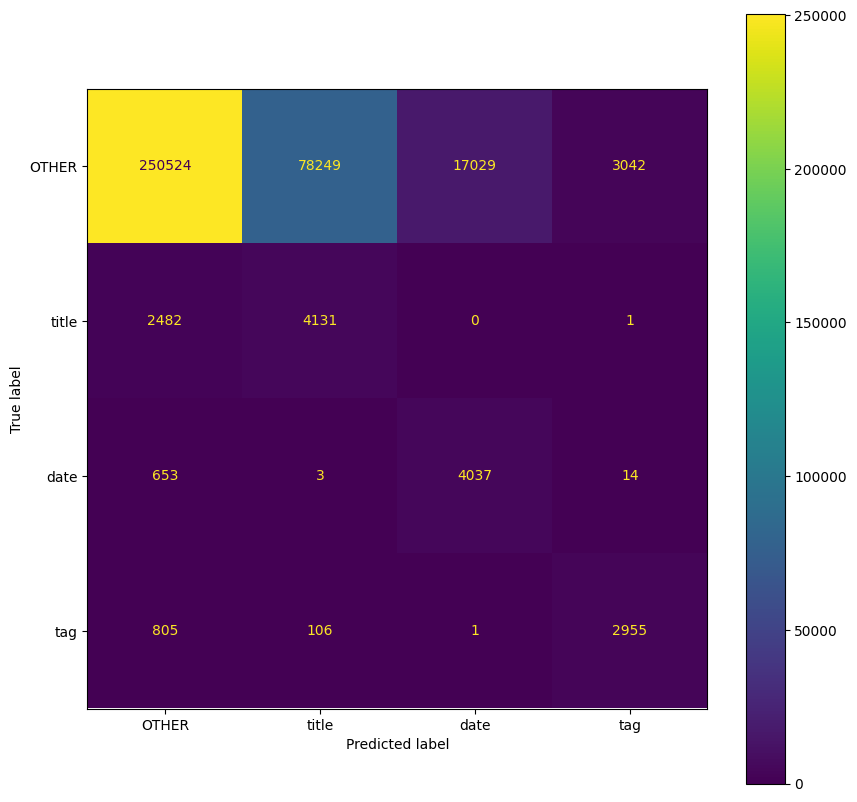

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(local_true, local_predicted)
d = ConfusionMatrixDisplay(matrix, display_labels=[v for k, v in id2label.items()])

fig, ax = plt.subplots(figsize=(10,10))
d.plot(ax=ax)